In [1]:
# declare the imports for building our neural network and displaying our data 
import tensorflow as tf
import PIL
import os
import h5py
import sys
import numpy as np
import pandas as pd
import random
import csv
import cv2
import fnmatch
import kerastuner as kt
import matplotlib.pyplot as plt 
from shutil import copyfile
from sklearn.model_selection import train_test_split
from numpy import asarray
from numpy import savetxt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization
from keras.utils import np_utils
from matplotlib import image
from os import listdir
from sklearn.metrics import classification_report
from keras import optimizers
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from kerastuner.applications import HyperXception
from tensorflow.keras.callbacks import EarlyStopping


# set the input and outpout Dirs
data_dir = 'C:\\Users\davie\Desktop\Final_Project\FYP\HCurve'
Output = 'C:\\Users\davie\Desktop\Final_Project\FYP\Processed_Data\\'

In [2]:
#load and examine the shape of the datat
X_train = np.load(Output+'xtrain32x32.npy')
Y_train = np.load(Output+'ytrain32x32.npy')
X_test = np.load(Output+'xtest32x32.npy')
Y_test = np.load(Output+'ytest32x32.npy')
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818,)
(3273,)


In [3]:
# building the input vector from the 256x256 pixels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [4]:
# one-hot encoding using keras
n_classes = 23
class_names = ['ABDMJ', 'Agen', 'Allaple', 'Autoit', 'Berbew', 'Bitman', 'Dinwod', 'Dorkbot', 
               'Dridex', 'Emotet', 'Fsysna', 'Hematite', 'InstallMonster', 'Oberal', 'Picsys', 
               'Salgorea', 'Scar', 'Sfone', 'Shifu', 'Socks', 'Sytro', 'Vilsel', 'Vobfus']
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (9818,)
Shape after one-hot encoding:  (9818, 23)


In [5]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818, 23)
(3273, 23)


In [6]:
def build_model(hp):
    model = keras.Sequential()
    # conv layer
    model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))
    # conv layer
    model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # conv layer
    model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # conv layer
    model.add(Conv2D(150, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # conv layer
    model.add(Conv2D(175, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # flatten output
    model.add(Flatten())
    # hidden layer
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(125, activation='relu'))
    model.add(Dropout(0.2))
    # output layer
    model.add(Dense(23, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [7]:
# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [9]:
tuner = Hyperband(build_model, objective="val_accuracy", max_epochs=30, hyperband_iterations=2, overwrite=True, 
                     directory=Output, project_name='AutoTuneHBV')

RuntimeError: Model-building function did not return a valid Keras Model instance, found <keras.engine.sequential.Sequential object at 0x0000023713D20A00>

In [17]:
# perform the hyperparameter search
print("[INFO] performing hyperparameter search...")
tuner.search(x=X_train, y=Y_train,validation_data=(X_test, Y_test), batch_size=100, callbacks=[es], epochs=30)
# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 180 Complete [00h 01m 54s]
val_accuracy: 0.08340971916913986

Best val_accuracy So Far: 0.9532539248466492
Total elapsed time: 02h 28m 21s
INFO:tensorflow:Oracle triggered exit


In [11]:
# build the best model and train it
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
history = model.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), batch_size=100,epochs=30, callbacks=[es], verbose=1)
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test, batch_size=100)
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

[INFO] training the best model...
Epoch 1/30
99/99 [==============================] - 33s 266ms/step - loss: 1.9087 - accuracy: 0.4332 - val_loss: 1.1847 - val_accuracy: 0.6462
Epoch 2/30
99/99 [==============================] - 26s 258ms/step - loss: 0.9491 - accuracy: 0.7168 - val_loss: 0.7833 - val_accuracy: 0.7904
Epoch 3/30
99/99 [==============================] - 25s 250ms/step - loss: 0.6923 - accuracy: 0.8007 - val_loss: 0.7159 - val_accuracy: 0.7843
Epoch 4/30
99/99 [==============================] - 26s 260ms/step - loss: 0.4848 - accuracy: 0.8641 - val_loss: 0.5490 - val_accuracy: 0.8500
Epoch 5/30
99/99 [==============================] - 25s 251ms/step - loss: 0.4039 - accuracy: 0.8836 - val_loss: 0.4353 - val_accuracy: 0.8888
Epoch 6/30
99/99 [==============================] - 26s 264ms/step - loss: 0.3789 - accuracy: 0.8910 - val_loss: 0.6136 - val_accuracy: 0.8100
Epoch 7/30
99/99 [==============================] - 25s 255ms/step - loss: 0.3244 - accuracy: 0.9066 - val_l

In [12]:
# evaluate the model and print the score to screen 
trainingscores = model.evaluate(X_train, Y_train, verbose=0)
testingscores = model.evaluate(X_test, Y_test, verbose=0)
print("[INFO] evaluating network")
predictions = model.predict(X_test, batch_size=100)
print("training scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], trainingscores[1]*100))
print("testing scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], testingscores[1]*100))

[INFO] evaluating network
training scores are below 

accuracy: 97.60%
testing scores are below 

accuracy: 95.20%


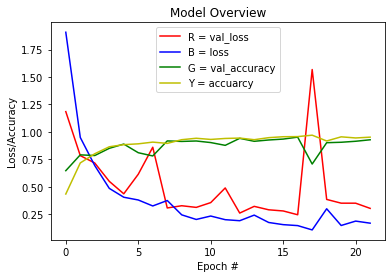

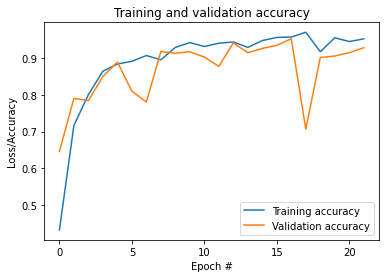

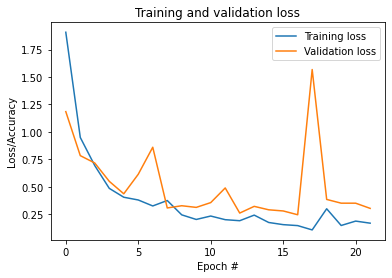

In [13]:
# Declare vars for the plotting of figures 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# overall model scoreing 
plt.plot(val_loss, 'r', loss, 'b', val_accuracy, 'g', accuracy, 'y')
label = 'R = val_loss', 'B = loss', 'G = val_accuracy', 'Y = accuarcy'
plt.title('Model Overview')
plt.legend(label)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# Training output 
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# testing output 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

In [ ]:
model.save(Output + "autoTuneHB.h5")
print("Saved model to disk")

In [13]:
from keras.models import load_model
import visualkeras
from PIL import ImageFont
from collections import defaultdict

#modPath = 'C:\\Users\davie\Desktop\Final_Project\FYP\Processed_Data\modelReFIT8.h5'
#model = keras.models.load_model(modPath)

#visualkeras.layered_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'yellow'
color_map[Dropout]['fill'] = 'red'
color_map[MaxPool2D]['fill'] = 'purple'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'gray'

font = ImageFont.truetype("arial.ttf", 20) 
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)  

NameError: name 'history' is not defined